In [53]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


faz os dados

In [54]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + np.random.normal(0,1)


z = FrankeFunction(x, y)

Vou plotar a superficie como está no site: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter3.html#exercises-and-projects

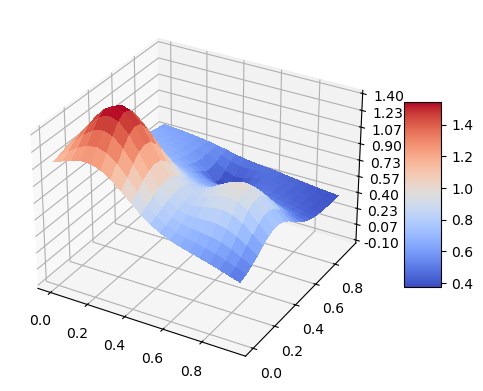

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Exercise: Ordinary Least Square (OLS) on the Franke function

In [56]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
z = FrankeFunction(x,y)

x_train,x_test,y_train,y_test,z_train,z_test = train_test_split(x,y,z,train_size=.7,random_state=5)

Vou fazer como o jensen quer e depois eu vou tentar fazer usando o sklearn. A primeira coisa que eu tenho que fazer é a matriz de design $\mathbf{X}$: $$\tilde y = \mathbf{X\beta}$$

Nesse caso, como é multivariado, é bem direito ainda. Perceba que as matrizes 

In [57]:
model = Pipeline([
    ('poly', PolynomialFeatures(5)),
    ('lin_model',LinearRegression())
])

In [58]:
X_train = np.c_[x_train,y_train]
X_train

array([[0.06060606, 0.06060606],
       [0.88888889, 0.88888889],
       [0.64646465, 0.64646465],
       [0.26262626, 0.26262626],
       [0.48484848, 0.48484848],
       [0.50505051, 0.50505051],
       [0.72727273, 0.72727273],
       [0.54545455, 0.54545455],
       [0.21212121, 0.21212121],
       [0.25252525, 0.25252525],
       [0.33333333, 0.33333333],
       [0.29292929, 0.29292929],
       [0.52525253, 0.52525253],
       [0.14141414, 0.14141414],
       [0.85858586, 0.85858586],
       [0.7979798 , 0.7979798 ],
       [0.95959596, 0.95959596],
       [0.03030303, 0.03030303],
       [0.43434343, 0.43434343],
       [0.11111111, 0.11111111],
       [0.98989899, 0.98989899],
       [0.45454545, 0.45454545],
       [0.83838384, 0.83838384],
       [0.67676768, 0.67676768],
       [0.8989899 , 0.8989899 ],
       [0.86868687, 0.86868687],
       [0.49494949, 0.49494949],
       [0.82828283, 0.82828283],
       [0.5959596 , 0.5959596 ],
       [0.19191919, 0.19191919],
       [0.

In [59]:
model.fit(X_train,z_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=5)),
                ('lin_model', LinearRegression())])

dados de treino:

In [60]:
mse = mean_squared_error(z_train,model.predict(X_train))
rmse = np.sqrt(mse)

In [61]:
print(f'rmse: {rmse}')
print(f'r2: {r2_score(z_train,model.predict(X_train))}')

rmse: 0.06110962348185816
r2: 0.977428729706676


In [62]:
X_test = np.c_[x_test,y_test]

Com os dados de teste agora:

In [63]:
mse = mean_squared_error(z_test,model.predict(X_test))
rmse = np.sqrt(mse)

In [64]:
print(f'rmse: {rmse}')
print(f'r2: {r2_score(z_test,model.predict(X_test))}')

rmse: 0.06902248383153718
r2: 0.973360132142308


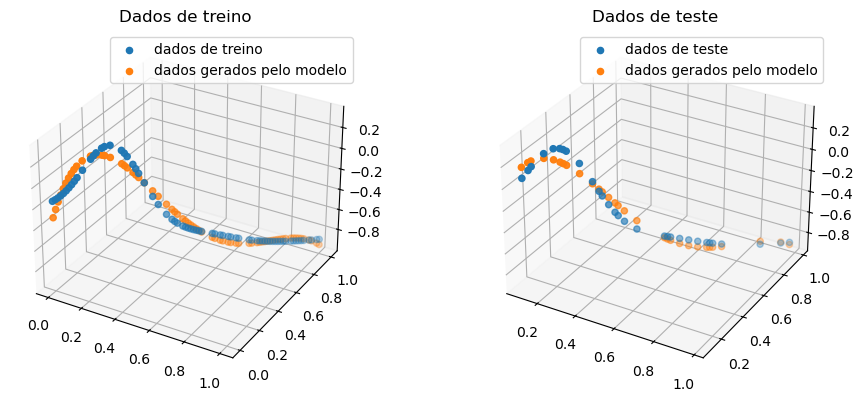

In [69]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4),subplot_kw={'projection': '3d'})


axes[0].scatter(x_train,y_train,z_train,label="dados de treino")
axes[0].scatter(x_train,y_train,model.predict(X_train),label='dados gerados pelo modelo')
axes[0].set_title("Dados de treino")
axes[0].legend()

axes[1].scatter(x_test,y_test,z_test,label='dados de teste')
axes[1].scatter(x_test,y_test,model.predict(X_test),label='dados gerados pelo modelo')
axes[1].set_title("Dados de teste")
axes[1].legend()

plt.tight_layout()
plt.show()